In [1]:
import numpy as np
from matplotlib import pyplot as plt

from scipy import constants
from scipy.interpolate import interp1d
from scipy.optimize import fmin
from scipy.integrate import quad, fixed_quad, quadrature

import lmfit

%matplotlib notebook

from labtools.mplplots.init_nb_plotting import *
from labtools.mplplots import plots as mplplots
from labtools.mplplots import tools as mpltools

In [27]:
def get_sample_data():
    data = np.loadtxt('./from_Pekola/NIS3_97mK.txt').T
    I = data[0,:]
    V = data[1,:]
    return I, V
    

def smooth(x, window_len=10):
    s = np.r_[x[window_len-1:0:-1], x, x[-2:-window_len-1:-1]]
    w = np.ones(window_len,'d')
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[int(window_len/2-1):int(-window_len/2)]


def find_offset(i, v, i_th=0.05, delta=1e-9, max_it=100, smooth_win=50):
    ifunc = interp1d(v, smooth(i, smooth_win))
    v_guess = v[np.argmin(abs(i-i_th))]
    v_pos = v_guess
    v_neg = -v_guess
    v_of = 0
    i_of = 0
    
    for k in range(max_it):  
        # for each iteration:
        # 1) using current i/v offsets, find v where i exceeds the threshold (both pos and neg side)
        # 2) update the v-offset by adding the mean of the new found values to the current one
        # 3) update i-offset (just the function value of i at the new 'zero' v value)
        v_pos = fmin(lambda v: abs(ifunc(v+v_of)-i_th-i_of), v_pos, disp=0, xtol=1e-8, ftol=1e-8)
        v_neg = fmin(lambda v: abs(ifunc(v+v_of)+i_th-i_of), v_neg, disp=0, xtol=1e-8, ftol=1e-8)
        v_of_new = v_of + (v_pos+v_neg)/2.

        if abs(v_of - v_of_new) < delta:
            v_of = v_of_new
            i_of = ifunc(v_of)
            break

        v_of = v_of_new
        i_of = ifunc(v_of)
        
        return i_of, v_of
    
def fermi(x, T, gap):
    beta = gap/(constants.k * T)
    return 1./(np.exp(beta * x) + 1)


def DoS_S(x, gamma):
    print(x, gamma)
    top = x + 1j * gamma
    bottom = np.sqrt(top**2-1)
    return abs((top/bottom).real)
    
    
def int_I(x, volt, TS, TN, RN, gap, gamma):   
    return DoS_S(x, gamma) * (fermi(x-constants.e*volt/gap, TN, gap) - fermi(x, TS, gap))


def INIS(volt, TS, TN, RN, gap, gamma):
    B = gap/(constants.e * RN)
    int_r = quad(lambda x : np.real(int_I(x, volt, TS, TN, RN, gap, gamma)), -10, -1)[0]
    int_i = quad(lambda x : np.imag(int_I(x, volt, TS, TN, RN, gap, gamma)), -10, -1)[0]
    return B * (int_r  + 1j * int_i)


def fit_linslope(i, v, imin=5e-3, imax=0.4):
    i2 = i[(i>imin) & (i<imax)]
    v2 = v[(i>imin) & (i<imax)]
    p = np.polyfit(np.log(i2), v2, 1)
    i_linfit = np.exp((v2-p[1])/p[0])
    T_slope = constants.e * p[0] * 1e-6 / constants.k
    
    return v2, i_linfit, T_slope

In [28]:
# get sample data, rescale to nA and uV
i, v = get_sample_data()
i *= 1e9
v *= 1e6

# find offset in i and v, correct
i_of, v_of = find_offset(i, v)
i -= i_of
v -= v_of

vfit, ifit, T = fit_linslope(i, v)

<IPython.core.display.Javascript object>


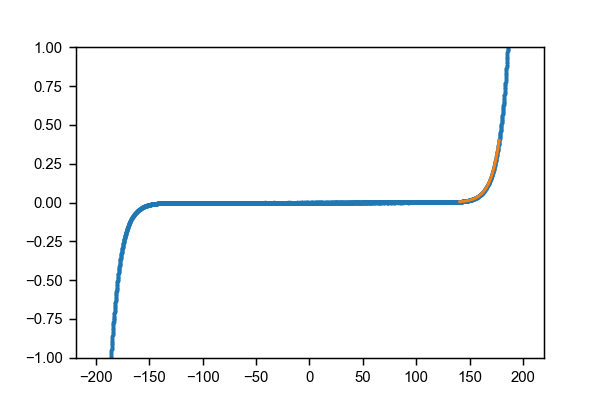

(-1, 1)

In [31]:
fig, ax = plt.subplots(1,1)
ax.plot(v, i, 'o', ms=1)
ax.plot(vfit, ifit)
ax.set_ylim(-1, 1)